In [1]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib notebook
print(tf.__version__)


1.12.0


## TF2.Keras MNIST Model 

> Use conda-enviroment tf2 

In [3]:
# Build Model 
mnist = tf.keras.Sequential([
  tf.keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

# Export Servable 
export_mnist_path = './servable/mnist/1/'

tf.keras.models.save_model(
    mnist,
    export_mnist_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./servable/mnist/1/assets


In [ ]:
tf.keras.utils.plot_model(mnist, show_shapes=True, dpi=64)

In [4]:
# Prepare Data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

test_images = test_images / 255.0
train_images = train_images / 255.0

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1) # [B, H, W, 1]

In [5]:
out = mnist(test_images[:1], training=False)
print('mnist output shape', out.shape)
print('mnist output type', type(out))
print('mnist output dtype', out.dtype)

# Input type can be either numpy array / tensor 
print('mnist input shape', test_images[:1].shape)
print('mnist inpur type', type(test_images[:1]))
print('mnist input dtype', test_images[:1].dtype)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

mnist output shape (1, 10)
mnist output type <class 'tensorflow.python.framework.ops.EagerTensor'>
mnist output dtype <dtype: 'float32'>
mnist input shape (1, 28, 28, 1)
mnist inpur type <class 'numpy.ndarray'>
mnist input dtype float64


In [6]:
# Start Docker & Servable 
# See README.md for more informaiton 

In [7]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_mnist_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [16]:
# Check ip:port connection 
!curl http://localhost:/8501/v1/models/mnist

curl: (56) Recv failure: Connection reset by peer


In [8]:
# Send request through REST 

import json
import random 
import requests

data = json.dumps({"signature_name": "serving_default", 
                   "instances": test_images[:1].tolist()})
headers = {"content-type": "application/json"}

# Without specify model version (use latest)
json_response = requests.post('http://localhost:8501/v1/models/mnist:predict', \
                              data=data, headers=headers)

json_response.text


'{ "error": "Failed to process element: 0 of \\\'instances\\\' list. Error: Invalid argument: JSON Value: 0.0 Type: Number is not of expected type: string" }'

In [ ]:
# Send request through gRPC

# pip3 install tensorflow-serving-api

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import grpc

def request_server(img, hostport):
    '''
    Input:
        img [1, H, W, 3] : input image
        hostport : tf server port 
    '''
    img = img.astype('float32')
    channel = grpc.insecure_channel(hostport)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "mnist"
    request.model_spec.signature_name = "serving_default"  # From signature_def['serving_default']:
    request.inputs["Conv1_input"].CopyFrom( # From inputs['Conv1_input'] tensor_info:
        tf.make_tensor_proto(img, shape=list(img.shape)))  
    response = stub.Predict(request, 5.0)  # 5 secs timeout
    return response

response = request_server(test_images[:1], '0.0.0.0:8500')
print(response.outputs['Softmax']) # From outputs['Softmax'] tensor_info:


## TF2.Keras Generator Model 

1. [TF Server RESTful API document](https://www.tensorflow.org/tfx/serving/api_rest)

2. [TF Server REST API Example](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)

In [9]:
# Build Model 
def downsample(filters, size, apply_batchnorm=True):
    '''
    Input Size: [B, H, W, C]
    '''
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    '''
    Input Size: [B, H, W, C]
    '''
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3]) # (None, 256, 256, 3)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()


In [11]:
# Plot Graph 
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=40)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [10]:
# Save Model 
export_generator_path = './servable/generator/1/'

tf.keras.models.save_model(
    generator,
    export_generator_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: ./servable/generator/1/assets


In [11]:
# Download data from https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz 
# Unzip data & put data under `./data/facades`

# Prepare data 
def load_img(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

input_img, real_img = load_img('./data/facades/train/100.jpg')

# Input of the model can be either numpy array / tensor 
# input_img = input_img.numpy()

print('input images type', type(input_img))
print('input images dtype', input_img.dtype)
print('input image shape', input_img[tf.newaxis,...].shape)

output_img = generator(input_img[tf.newaxis,...], training=False)

print('output images type', type(output_img))
print('output images dtype', output_img.dtype)
print('output image shape', output_img.shape)

plt.figure()
plt.imshow(output_img[0])
plt.axis('off')
plt.show()

print('output image range max : {}, min : {}'.format(  np.max(output_img.numpy()), np.min(output_img.numpy())   ))



input images type <class 'tensorflow.python.framework.ops.EagerTensor'>
input images dtype <dtype: 'float32'>
input image shape (1, 256, 256, 3)


In [ ]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_generator_path} --all


In [ ]:
# Send request through REST 

import json
import random 
import requests

data = json.dumps({"signature_name": "serving_default", 
                   "instances": input_img[tf.newaxis,...].numpy().tolist()})
headers = {"content-type": "application/json"}

# Without specify model version (use latest)
json_response = requests.post('http://localhost:8501/v1/models/generator:predict', \
                              data=data, headers=headers)

json_response



In [ ]:
output_img = json.loads(json_response.text)['predictions']
output_img = np.asarray(output_img)

plt.figure()
plt.imshow(output_img[0])
plt.axis('off')
plt.show()

print('output image max : {}, min : {}'.format(np.max(output_img), np.min(output_img)))

In [ ]:
# Send request through gRPC

def request_server(img, hostport):
    '''
    Input:
        img [1, H, W, 3] : input image
        hostport : tf server port 
    '''
    channel = grpc.insecure_channel(hostport)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "generator"
    request.model_spec.signature_name = "serving_default"  
    request.inputs["input_2"].CopyFrom(
        tf.make_tensor_proto(img, shape=list(img.shape)))  
    response = stub.Predict(request, 5.0)  # 5 secs timeout
    return response

response = request_server(input_img[tf.newaxis,...], '0.0.0.0:8500')
output_img = response.outputs['conv2d_transpose_15']
output_img = tf.make_ndarray(output_img)


In [ ]:
plt.figure()
plt.imshow(output_img[0])
plt.axis('off')
plt.show()

print('output image max : {}, min : {}'.format(np.max(output_img), np.min(output_img)))

## TF1.x Session MNIST Servable

> Use conda-enviroment tf1
> Use conda-enviroment tf2 

Save Servable using TF1.x, Test Servable using TF2.x (most model / client we use will be tf2)

**USE TF1 FOR CODE BELOW**

In [1]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 

print(tf.__version__)


2.0.0


In [23]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat

ImportError: cannot import name 'predict_pb2'

In [3]:
from reference.serving.tensorflow_serving.example import mnist_input_data

In [2]:
# Get Data 
mnist = mnist_input_data.read_data_sets('./data/mnist/', one_hot=True)
serialized_tf_example = tf.placeholder(tf.string, name='input_img')
feature_configs = {'x': tf.FixedLenFeature(shape=[784], dtype=tf.float32),}
tf_example = tf.parse_example(serialized_tf_example, feature_configs)


Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [4]:
sess = tf.InteractiveSession()
x = tf.identity(tf_example['x'], name='x') 
y_ = tf.placeholder('float', shape=[None, 10])
w = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())
y = tf.nn.softmax(tf.matmul(x, w) + b, name='y')
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
values, indices = tf.nn.top_k(y, 10)

for _ in range(10):
    batch = mnist.train.next_batch(50)
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
    #train_step.run(feed_dict={x: batch[0], y_: batch[1]})  


In [5]:
# Save Model 
classification_inputs = utils.build_tensor_info(serialized_tf_example)
classification_outputs = utils.build_tensor_info(values)
print('# \n',classification_inputs)
print('# \n',classification_outputs)

classification_signature = signature_def_utils.build_signature_def(
    inputs={signature_constants.CLASSIFY_INPUTS: classification_inputs},
    outputs={signature_constants.CLASSIFY_OUTPUT_SCORES:classification_outputs},
    method_name=signature_constants.CLASSIFY_METHOD_NAME)
print('# \n',classification_signature)



# 
 name: "input_img:0"
dtype: DT_STRING
tensor_shape {
  unknown_rank: true
}

# 
 name: "TopKV2:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
  dim {
    size: 10
  }
}

# 
 inputs {
  key: "inputs"
  value {
    name: "input_img:0"
    dtype: DT_STRING
    tensor_shape {
      unknown_rank: true
    }
  }
}
outputs {
  key: "scores"
  value {
    name: "TopKV2:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
      dim {
        size: 10
      }
    }
  }
}
method_name: "tensorflow/serving/classify"



In [6]:
tensor_info_x = utils.build_tensor_info(x)
tensor_info_y = utils.build_tensor_info(y)
print('# \n',tensor_info_x)
print('# \n',tensor_info_y)

prediction_signature = signature_def_utils.build_signature_def(
      inputs={'images': tensor_info_x},
      outputs={'scores': tensor_info_y},
      method_name=signature_constants.PREDICT_METHOD_NAME)
print('# \n',prediction_signature)


# 
 name: "x:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
  dim {
    size: 784
  }
}

# 
 name: "y:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
  dim {
    size: 10
  }
}

# 
 inputs {
  key: "images"
  value {
    name: "x:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
      dim {
        size: 784
      }
    }
  }
}
outputs {
  key: "scores"
  value {
    name: "y:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
      dim {
        size: 10
      }
    }
  }
}
method_name: "tensorflow/serving/predict"



In [7]:
# Save model 
export_mnist_path = './servable/mnist/1'

builder = saved_model_builder.SavedModelBuilder(export_mnist_path)

builder.add_meta_graph_and_variables(
sess, [tag_constants.SERVING],
signature_def_map={
    # Q : what's the difference between those 2
    'predict_images':prediction_signature,
    signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:classification_signature,})

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./servable/mnist/1/saved_model.pb


b'./servable/mnist/1/saved_model.pb'

In [8]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_mnist_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict_images']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['images'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 784)
        name: x:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: y:0
  Method name is: tensorflow/serving/predict

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_STRING
        shape: unknown_rank
        name: input_img:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: TopKV2:0
  Method name is: tensorflow/serving/classify


**USE TF2 FOR CODE BELOW**

In [36]:
# Prepare data 
test_data_set = mnist_input_data.read_data_sets('./data/mnist/').test
input_img, label = test_data_set.next_batch(1) 
print('input img shape', input_img.shape)
print('input img label', label)


Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
input img shape (1, 784)
input img label [7]


In [8]:
# Send gRPC request 
import grpc
import tensorflow as tf 
import tensorflow_serving.apis.predict_pb2 as predict_pb2
import tensorflow_serving.apis.prediction_service_pb2_grpc as prediction_service_pb2_grpc
from reference.serving.tensorflow_serving.example import mnist_input_data


Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [37]:
def request_server(img, hostport):
    '''
    Input:
        img [1, H, W, 3] : input image
        hostport : tf server port 
    '''
    channel = grpc.insecure_channel(hostport)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "mnist'"
    request.model_spec.signature_name = "predict_images"  
    print('request img shape', img.shape)
    request.inputs["images"].CopyFrom(
        tf.make_tensor_proto(img, shape=list(img.shape)))  
    response = stub.Predict(request, 10.0)  # 5 secs timeout
    return response

response = request_server(input_img, '0.0.0.0:8500')
#score = response.outputs['scores']
#score


request img shape (1, 784)


_Rendezvous: <_Rendezvous of RPC that terminated with:
	status = StatusCode.NOT_FOUND
	details = "Servable not found for request: Latest(mnist')"
	debug_error_string = "{"created":"@1583204832.049054000","description":"Error received from peer ipv4:0.0.0.0:8500","file":"src/core/lib/surface/call.cc","file_line":1055,"grpc_message":"Servable not found for request: Latest(mnist')","grpc_status":5}"
>

In [35]:
# Send REST request 
import json
import random 
import requests
import numpy as np 

data = json.dumps({"signature_name": "predict_images", 
                   "instances": input_img.tolist()})
headers = {"content-type": "application/json"}

# Without specify model version (use latest)
json_response = requests.post('http://localhost:8501/v1/models/mnist:predict', \
                              data=data, headers=headers)

output_scores = json.loads(json_response.text)['predictions']
output_scores = np.asarray(output_scores)
print('output score', output_scores)
print('output score shape', output_scores.shape)

output score [[0.02753951 0.00310099 0.00562662 0.01752279 0.01009459 0.02202833
  0.0062237  0.80996054 0.00724014 0.0906628 ]]
output score shape (1, 10)



## TF1.x Session Complex Style Transfer Servable

> Build servable with tf1.x 

> Test servable with tf2.x 


In [1]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 
import json
import random 
import argparse
import imageio 

%matplotlib inline

print(tf.__version__)

import sys
sys.path.append('.')
sys.path.append('./reference')
sys.path.append('./reference/style_transfer')

from reference.style_transfer.model import Artgan
from reference.style_transfer.module import * 
from reference.style_transfer.utils import * 

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat

1.12.0


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--is_training',
                    default=False)
parser.add_argument('--gf_dim',
                    default=32)
options = parser.parse_args(args=[])
options


Namespace(gf_dim=32, is_training=False)

In [3]:
# Build sess 
sess = tf.InteractiveSession()
input_photo = tf.placeholder(dtype=tf.float32,shape=[1, None, None, 3],name='input_photo')
input_photo_features = encoder(image=input_photo, options=options,reuse=False)
output_photo = decoder(features=input_photo_features,options=options,reuse=False)
saver = tf.train.Saver(max_to_keep=2)

# Activate variables
sess.run(tf.global_variables_initializer())


In [4]:
# Load weight 
model_name = 'van-gogh'
checkpoint_dir = './reference/style_transfer/models/model_{}/checkpoint_long/'.format(model_name)
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
saver.restore(sess, os.path.join(checkpoint_dir, ckpt_name))


INFO:tensorflow:Restoring parameters from ./reference/style_transfer/models/model_van-gogh/checkpoint_long/model16_van-gogh_bks10_flw100_300000.ckpt-300000


In [31]:
# Load imge 
#source_photo_dir =  './reference/style_transfer/data/sample_photographs'
#source_photo_file = 'Places365_val_00010148.jpg'
#target_photo_dir =  './reference/style_transfer/data/generated_sample_photographs'
#target_photo_file = 'generated_Places365_val_00010148.png'

source_photo_dir =  '~/Desktop'
source_photo_file = '1.jpeg'
target_photo_dir =  '~/Desktop'
target_photo_file = '1_out.jpg'

if not os.path.exists(target_photo_dir):
    os.makedirs(target_photo_dir)

input_img = imageio.imread(os.path.join(source_photo_dir, source_photo_file) )
print('input_img shape', input_img.shape)
print('input img type', type(input_img))

input_img = np.expand_dims(input_img, axis=0)


input_img shape (363, 391, 3)
input img type <class 'imageio.core.util.Array'>


In [20]:
def normalize_arr_of_imgs(arr):
    """
    Normalizes an array so that the result lies in [-1; 1].
    Args:
        arr: numpy array of arbitrary shape and dimensions.
        # TODO may also need to support input as tf.tensor 
    Returns:
    """
    return arr/127.5 - 1.

def denormalize_arr_of_imgs(arr):
    """
    Inverse of the normalize_arr_of_imgs function.
    Args:
        arr: numpy array of arbitrary shape and dimensions.
        # TODO may also need to support input as tf.tensor 
    Returns:
    """
    return (arr + 1.) * 127.5

In [21]:
# Run Model 
output_img = sess.run(
    output_photo, 
    feed_dict={
        input_photo: normalize_arr_of_imgs(input_img)
    }
)
output_img = denormalize_arr_of_imgs(output_img)
output_img = output_img[0]
print('output_img shape', output_img.shape)
print('output img type', type(output_img))
print('output img dtype', output_img.dtype)
print('output img range max : {}, min : {} '.format(np.max(output_img), np.min(output_img)))

plt.figure()
plt.axis('off')
plt.imshow(output_img)
plt.show()


In [1]:
from PIL import Image 
import numpy as np 

output_img_pil = Image.fromarray(np.uint8(output_img))
output_img_pil.save(os.path.join(target_photo_dir, target_photo_file))


NameError: name 'output_img' is not defined

In [17]:
# Save Model 
tensor_info_input_photo = utils.build_tensor_info(input_photo)
tensor_info_output_photo = utils.build_tensor_info(output_photo)

generate_signature = signature_def_utils.build_signature_def(
      inputs={'input_img': tensor_info_input_photo},
      outputs={'output_img': tensor_info_output_photo},
      method_name=signature_constants.PREDICT_METHOD_NAME)

# Save model 
export_style_transfer_path = './servable/{}/1'.format(model_name)
builder = saved_model_builder.SavedModelBuilder(export_style_transfer_path)
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={'predict_images':generate_signature,}
    )
builder.save()


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./servable/van-gogh/1/saved_model.pb


b'./servable/van-gogh/1/saved_model.pb'

In [9]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_style_transfer_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict_images']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: input_photo:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: decoder/sub:0
  Method name is: tensorflow/serving/predict


In [8]:
# Start TF Server 
# see `instruction.md` for more information 


In [8]:
!curl http://localhost:/8500/v1/models/model


curl: (56) Recv failure: Connection reset by peer


In [34]:
from PIL import Image
input_img = Image.open('/Users/xiaosong/Desktop/1.jpeg')
input_img = np.array(input_img)
input_img = np.expand_dims(input_img, axis=0)
print(input_img.shape)

(1, 363, 391, 3)


In [29]:
# Send RESTful request 
import json
import random 
import requests
import numpy as np 

data = json.dumps({"signature_name": "predict_images", 
                   "instances": input_img.tolist()})
headers = {"content-type": "application/json"}

# Without specify model version (use latest)
json_response = requests.post('http://localhost:8501/v1/models/model:predict', \
                              data=data, headers=headers)

json_response.text


'{ "error": "The first dimension of paddings must be the rank of inputs[4,2], [363,391,3]\\n\\t [[{{node encoder/MirrorPad}}]]" }'

In [17]:
output_img = json.loads(json_response.text)['predictions']
output_img = np.asarray(output_img)
output_img = output_img[0]
output_img = denormalize_arr_of_imgs(output_img)


output_img shape (448, 800, 3)
output img type <class 'numpy.ndarray'>
output img dtype float64
output img range max : 253.22277749999998, min : 0.2434604849999944 


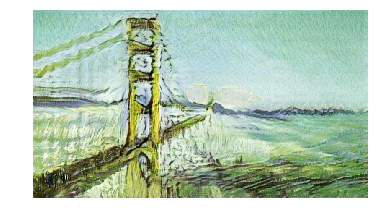

In [18]:
print('output_img shape', output_img.shape)
print('output img type', type(output_img))
print('output img dtype', output_img.dtype)
print('output img range max : {}, min : {} '.format(np.max(output_img), np.min(output_img)))

plt.figure()
plt.axis('off')
plt.imshow(np.uint8(output_img))
plt.show()

